# Oops... Nothing Here..  So, you are on your own this time.

# Data 

In [ ]:
!pip install wget
import wget

In [ ]:
import sys
print(sys.version)

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [ ]:
!pip install twython

In [ ]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

nltk.download('punkt')

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

from scipy.stats.kde import gaussian_kde

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Select hotels in Moose Jaw, Saskatchewan

#Functions

In [ ]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
          # assign sentimental score to the sentence and store in a panda dataframe
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

### Data Preprocessing
1. Find Topk words (No preprocessing steps now)
2. Reconstruct the above dataframe into CSV style..

In [ ]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            #counter.update([word.lower() 
            #                for word 
            #                in re.findall(r'\w+', review) 
            #                if word.lower() not in stop and len(word) > 2])
            
            counter.update([word.lower() 
                            for word 
                            in tokenize.word_tokenize(review)
                            if word.lower() not in stop and len(word) > 2])
            
            
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        #tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        tempCounter = Counter([word.lower() for word in tokenize.word_tokenize(reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [ ]:
#Rank the hotel by ground truth rating score
def getHotelRank_gt(df, measure='ratingScore'):
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgGtRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgGtRatingScore',ascending=0)
    return hotelRatingDfGt

In [ ]:
#Rank the hotel by vader score
def getHotelRank_vd(df, measure='vader'):
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfVd = pandas.DataFrame(hotelRating)
    hotelRatingDfVd.columns=['hotelName','avgVdScore']
    hotelRatingDfVd = hotelRatingDfVd.sort_values('avgVdScore',ascending=0)
    return hotelRatingDfVd

In [ ]:
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('stayed')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

#Q1. Sentiment Analysis and Aggregation

##(a)

In [ ]:
#Read in from pandas
hotelDf = pandas.read_csv('reviews.csv')
hotelDf.columns=['filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [ ]:
hotelDf.reset_index(drop=True)
hotelDf.head(5)

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,data/ca/155042/7050523/460517487.html,Home Inn &amp; Suites Regina Airport,"""Absolutely gorgeous hotel. Very modern and ex...",5,positive
1,data/ca/155042/7050523/520943774.html,Home Inn &amp; Suites Regina Airport,"""The staff and location was great,my only conc...",3,negative
2,data/ca/155042/7050523/512572517.html,Home Inn &amp; Suites Regina Airport,"""Spacious room, great for families. Friendly ...",4,positive
3,data/ca/155042/7050523/331045153.html,Home Inn &amp; Suites Regina Airport,"""The elevator service detracted from an otherw...",4,positive
4,data/ca/155042/7050523/430673194.html,Home Inn &amp; Suites Regina Airport,"""This is by far the best deal in Regina! The ...",5,positive


In [ ]:
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 7637/7637 [00:07<00:00, 1086.39it/s]


In [ ]:
reviewDF.head()

,reviewCol,vader
0,"""Absolutely gorgeous hotel. Very modern and ex...",0.9873
1,"""The staff and location was great,my only conc...",0.7269
2,"""Spacious room, great for families. Friendly ...",0.9001
3,"""The elevator service detracted from an otherw...",0.8442
4,"""This is by far the best deal in Regina! The ...",0.9593


In [ ]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=500)

In [ ]:
finaldf.head(5)

,hotelName,ratingScore,groundTruth,reviewCol,vader,room,hotel,stay,staff,great,pool,clean,good,rooms,breakfast,would,nice,n't,stayed,friendly,time,one,comfortable,service,night,desk,well,...,could,spa,front,get,place,area,also,like,bed,back,regina,location,...,lady,fact,car,along,families,overnight,inside,ready,wait,start,either,pleased,comfort,suites,sunday,daughter,disappointing,wine,nearby,doors,others,choices,instead,otherwise,visiting,makes,touch,appointed,group,meals,forward,anniversary,thanks,liked,nicely,real,seem,priced,team,holiday
0,Home Inn &amp; Suites Regina Airport,5,positive,"""Absolutely gorgeous hotel. Very modern and ex...",0.9873,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Home Inn &amp; Suites Regina Airport,3,negative,"""The staff and location was great,my only conc...",0.7269,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Home Inn &amp; Suites Regina Airport,4,positive,"""Spacious room, great for families. Friendly ...",0.9001,1,0,0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Home Inn &amp; Suites Regina Airport,4,positive,"""The elevator service detracted from an otherw...",0.8442,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Home Inn &amp; Suites Regina Airport,5,positive,"""This is by far the best deal in Regina! The ...",0.9593,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
hotelAnalysisDf = finaldf[['hotelName','ratingScore','vader']]
hotelAnalysisDf.head(5)

,hotelName,ratingScore,vader
0,Home Inn &amp; Suites Regina Airport,5,0.9873
1,Home Inn &amp; Suites Regina Airport,3,0.7269
2,Home Inn &amp; Suites Regina Airport,4,0.9001
3,Home Inn &amp; Suites Regina Airport,4,0.8442
4,Home Inn &amp; Suites Regina Airport,5,0.9593


In [ ]:
averageRating = hotelAnalysisDf.groupby('hotelName').mean()

In [ ]:
# compute the average Vader score and average ground truth rating
averageRating

,ratingScore,vader
hotelName,,
Best Western Plus Moose Jaw,4.168889,0.771534
Capone&#39;s Hideaway Theme Motel,2.040000,0.055428
Comfort Inn &amp; Suites,4.230769,0.828676
Comfort Suites Regina,4.447619,0.822865
Days Inn by Wyndham Moose Jaw,3.240909,0.472662
Days Inn by Wyndham Regina Airport West,4.118671,0.655660
Delta Hotels by Marriott Regina,3.924675,0.746605
Dreamland Motel,2.611111,0.101128
Fairfield Inn &amp; Suites by Marriott Regina,4.500000,0.858037


##(b)

In [ ]:
#Extract a list of hotels
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Home Inn &amp; Suites Regina Airport',
       'Fairfield Inn &amp; Suites by Marriott Regina',
       'The Atlas° Hotel', 'Days Inn by Wyndham Regina Airport West',
       'The Hotel Saskatchewan, Autograph Collection',
       'SureStay Plus Hotel by Best Western Seven Oaks',
       'Royal Hotel Regina, Trademark Collection by Wyndham',
       'Comfort Suites Regina', 'Four Points by Sheraton Regina',
       'Knights Inn Regina', 'Delta Hotels by Marriott Regina',
       'Residence Inn by Marriott Regina',
       'Holiday Inn Express Regina South', 'Pilgrim Inn',
       'Thriftlodge Moose Jaw', 'Prairie Oasis Tourist Complex',
       'MOOSEJAW INN', 'Dreamland Motel', 'Grant Hall Hotel',
       'Heritage Inn Hotel &amp; Convention Centre',
       'Temple Gardens Hotel &amp; Spa',
       'Redland Cottage Bed and Breakfast', 'Ramada by Wyndham Moose Jaw',
       'Days Inn by Wyndham Moose Jaw', 'Quality Inn &amp; Suites',
       'Wakamow Heights Bed and Breakfast', 'Best Western 

###(i)

In [ ]:
# get the average ground truth rating
hotelRatingDfGt = getHotelRank_gt(finaldf)

In [ ]:
hotelRatingDfGt

,hotelName,avgGtRatingScore
21,Redland Cottage Bed and Breakfast,5.000000
11,Residence Inn by Marriott Regina,4.633333
18,Grant Hall Hotel,4.592157
1,Fairfield Inn &amp; Suites by Marriott Regina,4.500000
7,Comfort Suites Regina,4.447619
25,Wakamow Heights Bed and Breakfast,4.413333
27,Knowles Motel,4.400000
24,Quality Inn &amp; Suites,4.371429
13,Pilgrim Inn,4.352941
4,"The Hotel Saskatchewan, Autograph Collection",4.326761


###(ii)

In [ ]:
# get the average Vader sentiment rating per hotel
hotelRatingDfVd = getHotelRank_vd(finaldf)

In [ ]:
hotelRatingDfVd

,hotelName,avgVdScore
25,Wakamow Heights Bed and Breakfast,0.880967
18,Grant Hall Hotel,0.880145
27,Knowles Motel,0.862920
11,Residence Inn by Marriott Regina,0.862439
1,Fairfield Inn &amp; Suites by Marriott Regina,0.858037
30,Comfort Inn &amp; Suites,0.828676
7,Comfort Suites Regina,0.822865
4,"The Hotel Saskatchewan, Autograph Collection",0.802961
21,Redland Cottage Bed and Breakfast,0.794000
24,Quality Inn &amp; Suites,0.784894


Get top 5 and bottom 5 hotels by ground truth ratings and Vader scores, repectively: 

In [ ]:
# get the top 5 hotels by ground truth
top5gt = hotelRatingDfGt.nlargest(5, 'avgGtRatingScore')
print('Top 5 hotels by ground truth ratings: ')
top5gt


Top 5 hotels by ground truth ratings: 


,hotelName,avgGtRatingScore
21,Redland Cottage Bed and Breakfast,5.000000
11,Residence Inn by Marriott Regina,4.633333
18,Grant Hall Hotel,4.592157
1,Fairfield Inn &amp; Suites by Marriott Regina,4.500000
7,Comfort Suites Regina,4.447619


In [ ]:
# get the top 5 hotels by Vader
top5vd = hotelRatingDfVd.nlargest(5, 'avgVdScore')
print('Top 5 hotels by Vader scores: ')
top5vd

Top 5 hotels by Vader scores: 


,hotelName,avgVdScore
25,Wakamow Heights Bed and Breakfast,0.880967
18,Grant Hall Hotel,0.880145
27,Knowles Motel,0.862920
11,Residence Inn by Marriott Regina,0.862439
1,Fairfield Inn &amp; Suites by Marriott Regina,0.858037


In [ ]:
# get bottom 5 hotels by ground truth
bottom5gt = hotelRatingDfGt.nsmallest(5, 'avgGtRatingScore')
print('Bottom 5 hotels by ground truth ratings: ')
bottom5gt

Bottom 5 hotels by ground truth ratings: 


,hotelName,avgGtRatingScore
29,Capone&#39;s Hideaway Theme Motel,2.040000
9,Knights Inn Regina,2.171429
16,MOOSEJAW INN,2.425532
15,Prairie Oasis Tourist Complex,2.533333
17,Dreamland Motel,2.611111


In [ ]:
# get the bottom 5 hotels by Vader
bottom5vd = hotelRatingDfVd.nsmallest(5, 'avgVdScore')
print('Bottom 5 hotels by Vader scores: ')
bottom5vd

Bottom 5 hotels by Vader scores: 


,hotelName,avgVdScore
29,Capone&#39;s Hideaway Theme Motel,0.055428
17,Dreamland Motel,0.101128
9,Knights Inn Regina,0.105220
15,Prairie Oasis Tourist Complex,0.173420
16,MOOSEJAW INN,0.330655


For the top 5, 2 out of the 5 are different. Redland Cottage Bed and Breakfast and Comfort Suites Regina are in the top 5 of ground truth but not in top 5 of Vader, while Wakamow Heights Bed and Breakfast and Knowles Motel are in top 5 of Vader but not in ground truth. The reason for the variation in Redland Cottage Bed and Breakfast might be that there are only 2 reviews on Tripadvisor website and both gave 5 stars. And for others, it could be the actual content of the comments is not as positive as the rating. 

Interestingly, for the bottom 5, although the order has some variation, the hotels are exactly the same for ground truth and Vader. When people are mad, they tend to be more consistent in the rating score and comments. 

However, there are hotels that have so few reviews. They could be outliers in this ranking and comparison since few reviews cannot actually reflect the quality of sevices provided by these hotels and are not so conclusive. Thus, we count the number of ratings each hotel has received (and we are able to crawl from the website) and add a threshold to exclude hotels with so few reviews. 

After going through all hotels of Moose Jaw, Saskachewan on the Tripadvisor website, the threshold is selected to be 15. Some hotels have say 100+ reviews but the crawler was only able to get 40 or 50 of them, but still, if remove this hotel, the ranking would be changed and not so consistent as the real case. So threshold is only 15. 

In [ ]:
# Ref: https://stackoverflow.com/questions/30485151/python-pandas-exclude-rows-below-a-certain-frequency-count
counts = finaldf['hotelName'].value_counts()
counts[counts > 15]
#counts
filter_finaldf = finaldf[finaldf['hotelName'].isin(counts[counts > 15].index)]
filter_finaldf.head(5)

,hotelName,ratingScore,groundTruth,reviewCol,vader,room,hotel,stay,staff,great,pool,clean,good,rooms,breakfast,would,nice,n't,stayed,friendly,time,one,comfortable,service,night,desk,well,...,could,spa,front,get,place,area,also,like,bed,back,regina,location,...,lady,fact,car,along,families,overnight,inside,ready,wait,start,either,pleased,comfort,suites,sunday,daughter,disappointing,wine,nearby,doors,others,choices,instead,otherwise,visiting,makes,touch,appointed,group,meals,forward,anniversary,thanks,liked,nicely,real,seem,priced,team,holiday
0,Home Inn &amp; Suites Regina Airport,5,positive,"""Absolutely gorgeous hotel. Very modern and ex...",0.9873,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Home Inn &amp; Suites Regina Airport,3,negative,"""The staff and location was great,my only conc...",0.7269,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Home Inn &amp; Suites Regina Airport,4,positive,"""Spacious room, great for families. Friendly ...",0.9001,1,0,0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Home Inn &amp; Suites Regina Airport,4,positive,"""The elevator service detracted from an otherw...",0.8442,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Home Inn &amp; Suites Regina Airport,5,positive,"""This is by far the best deal in Regina! The ...",0.9593,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# do the ranking again

# get the average ground truth rating
f_hotelRatingDfGt = getHotelRank_gt(filter_finaldf)

# get the average Vader sentiment rating per hotel
f_hotelRatingDfVd = getHotelRank_vd(filter_finaldf)

In [ ]:
# get the top 5 hotels by ground truth, with filter
f_top5gt = f_hotelRatingDfGt.nlargest(5, 'avgGtRatingScore')
print('Top 5 hotels (review counts > 15) by ground truth ratings: ')
f_top5gt

Top 5 hotels (review counts > 15) by ground truth ratings: 


,hotelName,avgGtRatingScore
11,Residence Inn by Marriott Regina,4.633333
18,Grant Hall Hotel,4.592157
1,Fairfield Inn &amp; Suites by Marriott Regina,4.500000
7,Comfort Suites Regina,4.447619
25,Wakamow Heights Bed and Breakfast,4.413333


In [ ]:
# get the top 5 hotels by Vader, with filter
f_top5vd = f_hotelRatingDfVd.nlargest(5, 'avgVdScore')
print('Top 5 hotels (review counts > 15) by Vader scores: ')
f_top5vd

Top 5 hotels (review counts > 15) by Vader scores: 


,hotelName,avgVdScore
25,Wakamow Heights Bed and Breakfast,0.880967
18,Grant Hall Hotel,0.880145
11,Residence Inn by Marriott Regina,0.862439
1,Fairfield Inn &amp; Suites by Marriott Regina,0.858037
30,Comfort Inn &amp; Suites,0.828676


In [ ]:
# get bottom 5 hotels by ground truth, with filter
f_bottom5gt = f_hotelRatingDfGt.nsmallest(5, 'avgGtRatingScore')
print('Bottom 5 hotels (review counts > 15) by ground truth ratings: ')
f_bottom5gt

Bottom 5 hotels (review counts > 15) by ground truth ratings: 


,hotelName,avgGtRatingScore
29,Capone&#39;s Hideaway Theme Motel,2.040000
9,Knights Inn Regina,2.171429
16,MOOSEJAW INN,2.425532
15,Prairie Oasis Tourist Complex,2.533333
17,Dreamland Motel,2.611111


In [ ]:
# get the bottom 5 hotels by Vader, with filter
f_bottom5vd = f_hotelRatingDfVd.nsmallest(5, 'avgVdScore')
print('Bottom 5 hotels (review counts > 15) by Vader scores: ')
f_bottom5vd

Bottom 5 hotels (review counts > 15) by Vader scores: 


,hotelName,avgVdScore
29,Capone&#39;s Hideaway Theme Motel,0.055428
17,Dreamland Motel,0.101128
9,Knights Inn Regina,0.105220
15,Prairie Oasis Tourist Complex,0.173420
16,MOOSEJAW INN,0.330655


After filtering, the hotel names are more consistent in both top 5 and bottom 5 lists for two measures despite the difference in the order of hotels. Only one variation in the top 5: Comfort Suit Regina (4.5 starts on the website) in ground truth, Comfort Inn and Suite (4.0 stars on the website) in Vader. 

#Q2. Frequency Analysis

##(a)

In [ ]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

In [ ]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')

In [ ]:
topkGroundPos

[('great', 2977),
 ('clean', 2467),
 ('good', 2263),
 ('breakfast', 2214),
 ('pool', 2179),
 ('nice', 1886),
 ('would', 1622),
 ('friendly', 1612),
 ('comfortable', 1378),
 ('time', 1193),
 ('well', 1132),
 ('service', 1100),
 ('one', 983),
 ('regina', 948),
 ('place', 897),
 ('area', 887),
 ('spa', 874),
 ('night', 873),
 ('excellent', 868),
 ('location', 850),
 ('desk', 788),
 ('also', 786),
 ('food', 769),
 ('helpful', 765),
 ('bed', 733),
 ('front', 732),
 ('beds', 727),
 ('get', 723),
 ('restaurant', 714),
 ('water', 701),
 ('back', 698),
 ('always', 693),
 ('hot', 684),
 ('enjoyed', 676),
 ('recommend', 668),
 ('moose', 655),
 ('like', 650),
 ('check', 644),
 ('jaw', 642),
 ('could', 634),
 ('quiet', 619),
 ('close', 612),
 ('really', 611),
 ('parking', 607),
 ('nthe', 595),
 ('definitely', 567),
 ('family', 542),
 ('free', 527),
 ('new', 522),
 ('little', 519)]

In [ ]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')

In [ ]:
topkGroundNeg

[('pool', 1244),
 ('would', 999),
 ('good', 762),
 ('one', 718),
 ('desk', 672),
 ('night', 645),
 ('clean', 631),
 ('time', 628),
 ('front', 627),
 ('breakfast', 613),
 ('nice', 610),
 ('get', 608),
 ('could', 586),
 ('spa', 535),
 ('like', 506),
 ('great', 480),
 ('bed', 459),
 ('back', 448),
 ('service', 441),
 ('also', 411),
 ('place', 406),
 ('area', 389),
 ('check', 382),
 ('even', 379),
 ('need', 372),
 ('water', 371),
 ('bathroom', 367),
 ('floor', 362),
 ('well', 360),
 ('told', 356),
 ('nthe', 347),
 ('friendly', 334),
 ('day', 324),
 ('parking', 320),
 ('hot', 314),
 ('old', 313),
 ('really', 313),
 ('next', 312),
 ('restaurant', 304),
 ('booked', 302),
 ('price', 301),
 ('door', 293),
 ('got', 289),
 ('much', 287),
 ('people', 287),
 ('went', 285),
 ('first', 283),
 ('kids', 281),
 ('beds', 280),
 ('small', 277)]

There are surprisingly many overlaps in the top 50 positive and negative non-stop words including 'good', 'great', 'nice', 'desk', 'clean', 'breakfast', 'pool', 'like', 'time' etc.. There are also locale-specific words like 'moose', 'jaw' and 'regina'. Examples for positive top 50: 'recommend', 'free', 'helpful', 'new', 'enjoyed', 'excellent', 'always', 'definitely' etc. Examples for negative top 50: 'old', 'told', 'much', 'even', 'need', 'bathroom', 'price' etc. 

The examples for positive top 50 mostly have much stronger strengh than the overlaps (e.g. good, great...). And it seems that people often complain about the price when the review is negative. They might think the service they received does not worth it. 

Another interesting finding is that there is a pair of antonym in positive and negative top 50: new vs old. It seems like when staying in a hotel, people always prefer new ones (maybe because the facilities are relatively cleaner and fancier).

##(b)

In [ ]:
tagger = PerceptronTagger()
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag

In [ ]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [ ]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [ ]:
# Noun Phrase Extraction Support Functions
# from nltk.corpus import stopwords
# Ref: https://stackoverflow.com/questions/46986560/wordlistcorpusreader-is-not-iterable
stop = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stop)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [ ]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [ ]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [ ]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF)

In [ ]:
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,front desk,moo jaw,pool area,hot tub,templ garden,miner pool,front desk staff,great place,water slide,continent breakfast,first time,park lot,free breakfast,hotel room,great stay,next time,great locat,room servic,hotel staff,friendli staff,clean staff,comfort bed,next day,day inn,miner spa,dine room,next morn,custom servic,water park,nthe room,nice hotel,breakfast area,great hotel,clean room,great time,good valu,miner water,credit card,night stay,good locat,easi access,complimentari breakfast,main street,air condition,good experi,good place,queen bed,great experi,nthe hotel,great room
0,Home Inn &amp; Suites Regina Airport,5,positive,"""Absolutely gorgeous hotel. Very modern and ex...",0.9873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Home Inn &amp; Suites Regina Airport,3,negative,"""The staff and location was great,my only conc...",0.7269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Home Inn &amp; Suites Regina Airport,4,positive,"""Spacious room, great for families. Friendly ...",0.9001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Home Inn &amp; Suites Regina Airport,4,positive,"""The elevator service detracted from an otherw...",0.8442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Home Inn &amp; Suites Regina Airport,5,positive,"""This is by far the best deal in Regina! The ...",0.9593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def getTopK_phrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    #stop.add('moo')
    #stop.add('jaw')  no difference, stop words are not used in noun phrase top k function
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)
    return topk

In [ ]:
itemAnalysisDf_phrase = finaldf_phrase[['reviewCol','groundTruth','vader']]

In [ ]:
topkGroundPos_phrase = getTopK_phrase(df=itemAnalysisDf_phrase, k=50, label_value='positive')

In [ ]:
topkGroundPos_phrase

[('moo jaw', 405),
 ('front desk', 251),
 ('hot tub', 156),
 ('great place', 147),
 ('templ garden', 135),
 ('pool area', 128),
 ('front desk staff', 109),
 ('miner pool', 101),
 ('continent breakfast', 95),
 ('great stay', 94),
 ('free breakfast', 91),
 ('water slide', 86),
 ('great locat', 83),
 ('first time', 83),
 ('friendli staff', 78),
 ('park lot', 75),
 ('comfort bed', 73),
 ('next time', 71),
 ('hotel staff', 65),
 ('dine room', 64),
 ('great time', 58),
 ('clean staff', 57),
 ('room servic', 57),
 ('hotel room', 56),
 ('clean room', 56),
 ('great hotel', 56),
 ('miner spa', 56),
 ('water park', 53),
 ('breakfast area', 52),
 ('day inn', 52),
 ('nice hotel', 51),
 ('easi access', 50),
 ('complimentari breakfast', 49),
 ('good valu', 46),
 ('main street', 46),
 ('good place', 46),
 ('miner water', 46),
 ('good experi', 43),
 ('great experi', 42),
 ('good locat', 41),
 ('great servic', 41),
 ('night stay', 41),
 ('nthe room', 41),
 ('new hotel', 39),
 ('great room', 39),
 ('cust

In [ ]:
topkGroundNeg_phrase = getTopK_phrase(df=itemAnalysisDf_phrase, k=50, label_value='negative')

In [ ]:
topkGroundNeg_phrase

[('front desk', 312),
 ('moo jaw', 141),
 ('pool area', 107),
 ('miner pool', 74),
 ('hot tub', 69),
 ('front desk staff', 53),
 ('water slide', 52),
 ('next day', 50),
 ('credit card', 47),
 ('templ garden', 47),
 ('park lot', 45),
 ('hotel room', 44),
 ('next morn', 42),
 ('first time', 38),
 ('custom servic', 37),
 ('air condition', 37),
 ('room servic', 35),
 ('nthe room', 31),
 ('last time', 29),
 ('day inn', 29),
 ('continent breakfast', 29),
 ('free breakfast', 28),
 ('hotel staff', 27),
 ('good thing', 26),
 ('clean staff', 26),
 ('first night', 26),
 ('next time', 26),
 ('hot water', 24),
 ('miner spa', 23),
 ('bathroom door', 21),
 ('differ room', 21),
 ('desper need', 21),
 ('second floor', 21),
 ('nice room', 20),
 ('main floor', 20),
 ('doubl bed', 20),
 ('nice hotel', 19),
 ('water park', 19),
 ('nthe hotel', 19),
 ('late check', 19),
 ('jacuzzi suit', 19),
 ('mani time', 18),
 ('breakfast area', 17),
 ('room rate', 17),
 ('night stay', 17),
 ('queen bed', 17),
 ('big dea

There are also many overlaps in the noun phrases for positive and negative ground truth sentiment including 'moo jaw', 'front desk', 'hot tub', 'front desk staff', 'park lot', and even 'nice hotel' etc.

And for the positive reviews, there are specific noun phrases like 'great xxx (place, stay, time, hotel experience.)' which have stronger positive adjectives (specifically, stronger than 'good') whereas in negative reviews, there are also noun phrase starting with 'good', which could imply that when people critized the hotel, they also pointed out some aspects that are good there to provide more references for others, or, they wrote it with negation like 'not good...'. 

Additionally, there is a noun phrase 'air condition' appearing only in negative reviews, from which we could imply that some hotel has problems with their air conditioning. It seems that people tend to be specific when they complain about their stays. 

#Q3. Mutual Information

##(a)

In [ ]:
# get Top K mutual information terms from the dataframe

# in our case, x is the word, y is the ground truth label
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
        #print(word)
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word/Phrase','MI Score']
    return miScoredf

In [ ]:
miScoredf = getMI(topk, finaldf)

In [ ]:
miScoredf[:50]

,Word/Phrase,MI Score
222,dirty,0.022665
4,great,0.022345
12,n't,0.019523
104,told,0.019450
23,could,0.011978
317,carpet,0.011710
419,terrible,0.011633
126,said,0.011026
40,excellent,0.010896
60,need,0.010831


Although there are words with clearly positive or negative sentiment, it is still hard to tell whether the review containing this word is positive or negative. Specifically, for example, the word 'friendly', it is positive but the review can also be 'the front desk staff is not friendly' which has a negation. There are also words that are more likelly to be positive than negative, such as 'excellent' and 'spacious', but just few like them. There are two cases: always co-occur, or barely co-occur. These two cases can both result in high MI score. So, using MI of words here does not seem so conclusive. 

##(b)

In [ ]:
miScoredf_phrase = getMI(topk_phrase, finaldf_phrase)
pandas.set_option('display.precision',10)

In [ ]:
miScoredf_phrase[:50]

,Word/Phrase,MI Score
0,front desk,0.0096488335
37,credit card,0.0031325869
7,great place,0.0025198781
43,air condition,0.0024917728
22,next day,0.0021391987
2,pool area,0.0021058973
14,great stay,0.0020712318
34,great time,0.0014094446
26,next morn,0.0013906574
16,great locat,0.0009811939


Noun phrases are more informative. It seems that when people live in a hotel, they care about the front desk, the bed, the bathroom, customer services and the dining area. Also, there is locale-specific noun phrase like 'moo (moose) jaw'. Some hotels seem to have a water slide that many reviews mentioned it. 

But still, looking only at the MI of noun phrase cannot tell anything about the actual sentiment of the reviews. There are two cases, either always co-occur, or never co-occur, that can both result in high MI score. 

#Q4. Pointwise Mutual Information

##(a)

In [ ]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [ ]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [ ]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word/phrase','pmi']
    pmineglist.columns = ['word/phrase','pmi']
    pmidf.columns = ['word/phrase','pmi']
    return pmiposlist, pmineglist, pmidf

In [ ]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████| 500/500 [00:22<00:00, 22.46it/s]


In [ ]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
214,perfect,0.2800916451
253,highly,0.2645117083
388,delicious,0.2547738371
116,spacious,0.2271759614
85,wonderful,0.2267537087
492,thanks,0.2206951756
125,amazing,0.2189937716
40,excellent,0.2183118299
371,variety,0.2168173230
226,accommodating,0.2106568862


In [ ]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
222,dirty,1.1287318822
419,terrible,1.0810896131
447,paint,1.0095740937
476,disappointing,1.0044453903
317,carpet,0.9853734504
332,walls,0.9796700556
323,poor,0.9597820624
394,smell,0.9462703903
104,told,0.9453494951
325,paid,0.9317566999


For positive reviews, we can conclude that people like large rooms because the word 'spacious' has a high rank. 'Highway' and 'downtown' also occur in the top 50, and it might be because in Moose Jaw, people prefer to live in hotels close to or in the downtown and can easily access to the highway. 

For negative reviews, many of the words are related to the cleaness and noise level in the hotel rooms. It seems like people complain most about too dirty room/carpet and bad noise isolation, and they might often mention that the money they paid for the staying was not worth it since the words 'money' and 'paid' also get high ranks. 

##(b)

In [ ]:
pmiposlist_phrase, pmineglist_phrase, pmidf_phrase = pmiForAllCal(finaldf_phrase,topk=topk_phrase)

100%|██████████| 50/50 [00:01<00:00, 34.25it/s]


In [ ]:
#Sorted top pmi phrases for positive reviews
pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
34,great time,0.2786011732
14,great stay,0.2673741106
7,great place,0.2428830906
40,easi access,0.2327307192
21,comfort bed,0.2136346615
33,clean room,0.2121114320
19,friendli staff,0.2092664798
16,great locat,0.2054402931
45,good place,0.1992742852
41,complimentari breakfast,0.1963630750


In [ ]:
#Sorted top pmi phrases for negative reviews
pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
37,credit card,1.0027705484
43,air condition,0.9016744316
22,next day,0.7413317815
26,next morn,0.6407905523
0,front desk,0.6345209393
27,custom servic,0.5032268961
2,pool area,0.4938810337
29,nthe room,0.4407065391
13,hotel room,0.4082602999
5,miner pool,0.3561901464


For the positive reviews, many of them are just general phrases like 'great place', 'great stay' and 'great time'. But there are also specific phrases pointing to some aspects of the hotel. Many customers have compliment the breakfast of the hotels in the positive reviews, including the free breakfast and the continental breakfast. 

For the negative reviews, many people seem to have issues with their credit card payment when living in some hotels since the noun phrase 'credit card' ranked top 1. Also, air conditioning seems to have problem in some hotels. Another interesting point is the phrase 'front desk' having high rank. It might be because people get more upset when the problem occurs but no one working in the hotel is helful. From this analysis, the water slide in some hotel seems to annoy people rather than attracting them. 

##(c)

Let's use the results after filtering (crawled review counts > 15) since they are more conclusive. 

In [ ]:
#Top1Df = hotelDf[hotelDf['hotelName']=='Temple Gardens Hotel &amp; Spa']
Top1Df = hotelDf[hotelDf['hotelName']=='Residence Inn by Marriott Regina']
Top1Df = Top1Df.reset_index(drop=True)

Bottom1Df = hotelDf[hotelDf['hotelName']=='Dreamland Motel']
Bottom1Df = Bottom1Df.reset_index(drop=True)

top1_reviews = Top1Df['reviewColumn'].values
top1_reviewDF = evalSentences(top1_reviews, to_df=True, columns=['reviewCol','vader'])

bottom1_reviews = Bottom1Df['reviewColumn'].values
bottom1_reviewDF = evalSentences(bottom1_reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 18/18 [00:00<00:00, 885.90it/s]


In [ ]:
topk_top1, finaldf_top1 = dataFrameTransformation(Top1Df, top1_reviewDF, k=500)
topk_bottom1, finaldf_bottom1 = dataFrameTransformation(Bottom1Df, bottom1_reviewDF, k=500)

In [ ]:
top1_pmiposlist, top1_pmineglist, top1_pmidf = pmiForAllCal(finaldf_top1, topk=topk_top1)
bottom1_pmiposlist, bottom1_pmineglist, bottom1_pmidf = pmiForAllCal(finaldf_bottom1,topk=topk_bottom1)

100%|██████████| 473/473 [00:06<00:00, 76.39it/s]


In [ ]:
#Sorted top pmi words for positive reviews, top 1 hotel by ground truth ratings
top1_pmiposlist.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
499,heard,0.0454623741
226,going,0.0454623741
207,including,0.0454623741
208,ice,0.0454623741
210,centre,0.0454623741
211,early,0.0454623741
217,choice,0.0454623741
433,recently,0.0454623741
219,love,0.0454623741
220,sized,0.0454623741


In [ ]:
#Sorted top pmi words for negative reviews, top 1 hotel by ground truth ratings
top1_pmineglist.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
396,snow,3.1135153092
316,construction,2.7080502011
439,per,2.4203681287
443,sleep,2.4203681287
314,several,2.4203681287
313,road,2.4203681287
440,security,2.4203681287
442,recent,2.4203681287
441,appears,2.4203681287
444,normal,2.4203681287


In [ ]:
#Sorted top pmi words for positive reviews, bottom 1 hotel by ground truth ratings
bottom1_pmiposlist.sort_values('pmi',ascending=0).head(50)
#bottom1_pmiposlist.sort_values('pmi',ascending=0)[101:150]

,word/phrase,pmi
236,tunnels,0.9444616088
221,walking,0.9444616088
208,evening,0.9444616088
209,\n\ni,0.9444616088
210,much,0.9444616088
211,travellers,0.9444616088
212,continuing,0.9444616088
213,highway,0.9444616088
214,however,0.9444616088
215,ideal,0.9444616088


In [ ]:
#Sorted top pmi words for negative reviews, bottom 1 hotel by ground truth ratings
bottom1_pmineglist.sort_values('pmi',ascending=0).head(50)
#bottom1_pmineglist.sort_values('pmi',ascending=0)[250:299] 

,word/phrase,pmi
472,head,0.4924764851
364,outright,0.4924764851
366,refuses,0.4924764851
367,prepaid,0.4924764851
368,advertised,0.4924764851
369,sub-standard,0.4924764851
370,dive,0.4924764851
371,grossly,0.4924764851
372,favour,0.4924764851
373,elsewhere,0.4924764851


In [ ]:
topk_top1_phrase, finaldf_top1_phrase = newDataFrameTransformation(Top1Df, top1_reviewDF)
topk_bottom1_phrase, finaldf_bottom1_phrase = newDataFrameTransformation(Bottom1Df, bottom1_reviewDF)

In [ ]:
top1_pmiposlist_phrase, top1_pmineglist_phrase, top1_pmidf_phrase = pmiForAllCal(finaldf_top1_phrase, topk=topk_top1_phrase)
bottom1_pmiposlist_phrase, bottom1_pmineglist_phrase, bottom1_pmidf_phrase = pmiForAllCal(finaldf_bottom1_phrase,topk=topk_bottom1_phrase)

100%|██████████| 50/50 [00:00<00:00, 76.16it/s]


In [ ]:
#Sorted top pmi phrase for positive reviews, top 1 hotel by ground truth ratings
top1_pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
0,full kitchen,0.0454623741
38,fit room,0.0454623741
28,public space,0.0454623741
29,first class,0.0454623741
30,new hotel,0.0454623741
31,nthe staff,0.0454623741
32,conveni store,0.0454623741
33,nthe hotel,0.0454623741
34,hotel breakfast,0.0454623741
36,excel stay,0.0454623741


In [ ]:
#Sorted top pmi phrase for negative reviews, top 1 hotel by ground truth ratings
top1_pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
35,free park,2.4203681287
24,good breakfast,2.4203681287
15,hotel room,2.0149030205
4,park lot,1.7272209481
7,liquor store,1.7272209481
43,difficult visit,-1.5970153924
21,busi stop,-1.5970153924
42,sick sister,-1.5970153924
29,first class,-1.5970153924
46,busi center,-1.5970153924


In [ ]:
#Sorted top pmi phrase for positive reviews, bottom 1 hotel by ground truth ratings
bottom1_pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
25,main area,0.9444616088
27,local tourist attract,0.9444616088
19,easi nthe room,0.9444616088
18,warm friendli servic,0.9444616088
17,good famili,0.9444616088
22,even ni,0.9444616088
23,east end locat,0.9444616088
24,littl drive,0.9444616088
1,dreamland motel,0.9444616088
26,avail downtown,0.9444616088


In [ ]:
#Sorted top pmi phrase for negative reviews, bottom 1 hotel by ground truth ratings
bottom1_pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,word/phrase,pmi
49,never book room dump,0.4924764851
35,new ownership,0.4924764851
37,good thing,0.4924764851
38,first time,0.4924764851
39,impress ndoor lock,0.4924764851
40,shut nfurnac work ncoffe pot,0.4924764851
41,old coffe ground,0.4924764851
42,carpet nnot,0.4924764851
43,okay bathroom,0.4924764851
44,air condition work,0.4924764851


For top 1 hotel, the top 50 positive reviews all have same values. By looking into the actual dataset, I found that there are 90 reviews in total and only 4 of them are negative, all other 86 are postive. So the reviews are highly skewed towards postive sentiment, and no matter what words appear in the comment, it co-occurs with the positive ground truth sentiment. 


The only measure that could make some sense is the negative reviews for the top 1 hotel. It seems like the hotel is going through some construction and the snow is a bit annoying as well. 

The PMIs for bottom 1 hotel positive and negative are the same, and cannot really provide much insight. The reason could be, this hotel has so few reviews, 18 in total, and 11 out of 18 are negative. Although not that much, it is still skewed towards the negative. And that could be the reason why the top 50 of positive reviews have same pmi score and if we go after 100+ the pmi starts to vary. Same case can be found in the negative reviews. 

I also tried with the hotel having 2000+ reviews, the PMIs are different and provide more hotel specific insights e.g. the location is good, the food is delicious and the rooms are spacious etc.. 

#Q5. General Plots

##Histograms

###(a)

In [ ]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

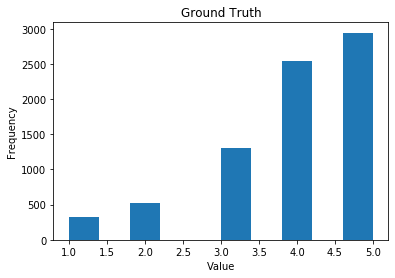

In [ ]:
getHistogram('ratingScore', 'Ground Truth')

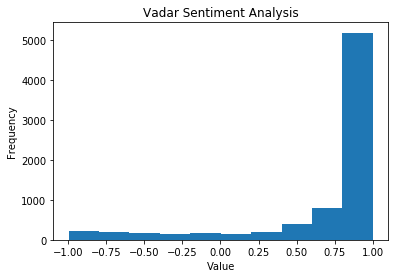

In [ ]:
getHistogram('vader', 'Vadar Sentiment Analysis')

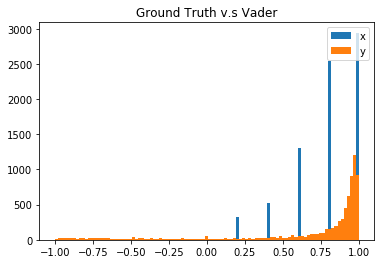

In [ ]:
getHistogram('both', 'Ground Truth v.s Vader')
# x = ground truth rating, y = vader

The ground truth rating and Vader score have the same trend in general, i.e. frequency increasing as the rating/score increasing. But for the Vader score, there is a decreasing trend from -1 to 0. Negative Vader score could implies a negative review, so this trend could be because when people have neutral sentiment, they tend not to leave comment. 

Another finding is that when people are satisfied with the hotel, they are more likely to leaving a review to compliment it whereas when they are not happy with the stay, they are less likely to commenting it. 

###(b)

In [ ]:
# get a dataframe store hotel names and corresponding num of reviews received
# Ref: see RS assignment Q7
review_counts = hotelDf.groupby('hotelName').count().reset_index()
review_counts.drop('filePath', axis = 1, inplace = True)
review_counts.drop('ratingScore', axis = 1, inplace = True)
review_counts.drop('groundTruth', axis = 1, inplace = True)

review_counts.columns = ['hotelName', 'numReviews']

review_counts 

#review_counts.sort_values(by=['numReviews'],ascending=False) 

,hotelName,numReviews
0,Best Western Plus Moose Jaw,225
1,Capone&#39;s Hideaway Theme Motel,25
2,Comfort Inn &amp; Suites,143
3,Comfort Suites Regina,210
4,Days Inn by Wyndham Moose Jaw,220
5,Days Inn by Wyndham Regina Airport West,632
6,Delta Hotels by Marriott Regina,385
7,Dreamland Motel,18
8,Fairfield Inn &amp; Suites by Marriott Regina,60
9,Four Points by Sheraton Regina,58


Text(0, 0.5, 'num. of reviews')

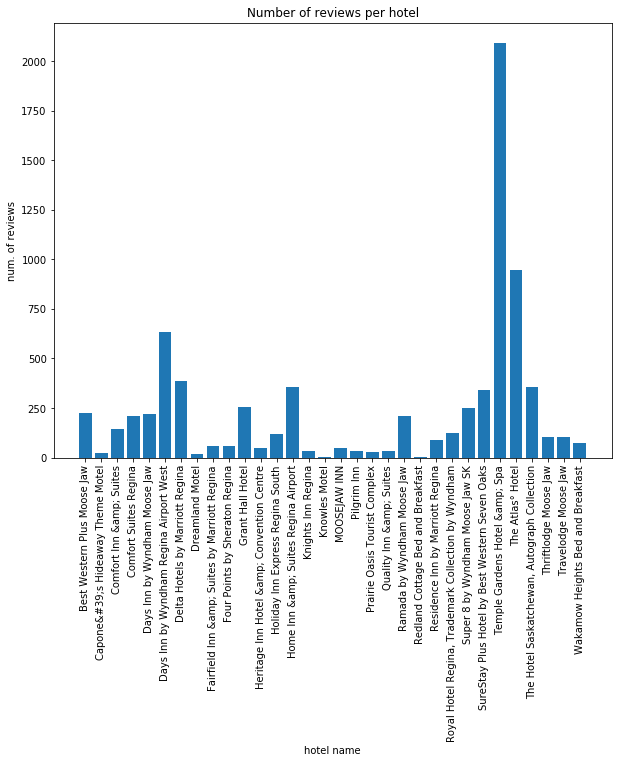

In [ ]:
plt.figure(figsize = (10,8))
plt.xticks(rotation=90)

plt.bar(review_counts['hotelName'],review_counts['numReviews'])
plt.title('Number of reviews per hotel')
plt.xlabel('hotel name')
plt.ylabel('num. of reviews')


Text(0.5, 1.0, 'Reviews per Hotel')

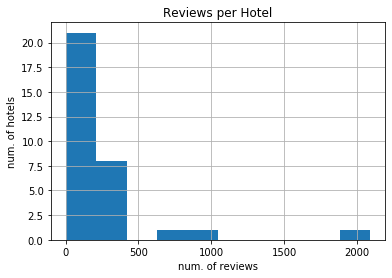

In [ ]:
review_counts.hist()
plt.xlabel('num. of reviews')
plt.ylabel('num. of hotels')
plt.title('Reviews per Hotel')

Most of the hotels have less than 400 reviews and only 3 hotels have more than 600 reviews. It is as expected since most of the hotels in Moose Jaw are not very large, and only 1 or 2 of them are large and have various facilities (e.g. Temple Garden Hotel & Spa). These large hotels tend to have more stays and have more reviews whereas the small ones tend to have similar facilities (i.e. choosing A does not differentiate much than choosing B) and thus the reviews are distributed. 

##Boxplots

###(a)

Again, use the data after filtering. 

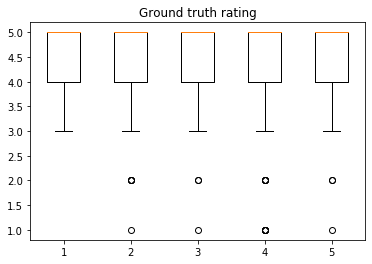

In [ ]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = f_hotelRatingDfGt.sort_values('avgGtRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

top1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
top2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
top3 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
top4 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
top5 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data_gt = [top1, top2, top3, top4, top5]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_gt)
plt.title('Ground truth rating')
plt.show()

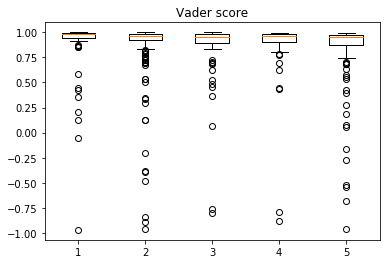

In [ ]:
#Plot top 5 side-by-side boxplot for top 5 vader score hotels
tp5vdhotel = f_hotelRatingDfVd.sort_values('avgVdScore',ascending=0).head(5)
tp5vdhotel['hotelName'].values

top1 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[0]]['vader']
top2 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[1]]['vader']
top3 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[2]]['vader']
top4 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[3]]['vader']
top5 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[4]]['vader']

data_vd = [top1, top2, top3, top4, top5]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_vd)
#plt.ylim([0.5,1]) # if not adjustment here, the boxplot would be concentrated on the upper side
plt.title('Vader score')
plt.show()

###(b)

In [ ]:
def calc_mean_var(data): 
  mean_var = []
  for hotel in data: 
    mean_var.append([hotel.mean(),hotel.var()])
  
  mean_var_df = pandas.DataFrame(mean_var)
  mean_var_df.columns = ['mean','variance']
  return mean_var_df

In [ ]:
stats_gt = calc_mean_var(data_gt)
stats_gt

,mean,variance
0,4.6333333333,0.3247191011
1,4.5921568627,0.5180484792
2,4.5000000000,0.6949152542
3,4.4476190476,0.8704488494
4,4.4133333333,0.7322522523


In [ ]:
stats_vd = calc_mean_var(data_vd)
stats_vd

,mean,variance
0,0.8809666667,0.0904790544
1,0.8801450980,0.0787218887
2,0.8624388889,0.0852131948
3,0.8580366667,0.1143280915
4,0.8286755245,0.1105244293


###(c) 
The boxplots are more informative. They contain more information than the mean and variance. From the boxplot, we can not only see the variance but also see how the rating scores and Vader are distributed as well as the outliers. 

##Scatterplots and Heatmaps

###(a)

In [ ]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
def scatterplot(x, y, x_label, y_label):
  plt.plot(x, y,"o")
  plt.ylabel(y_label)
  plt.xlabel(x_label)

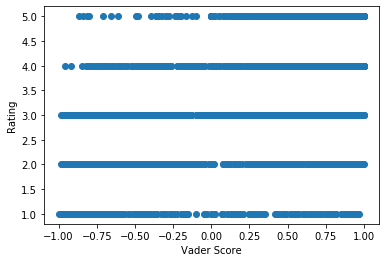

In [ ]:
scatterplot(x,y,'Vader Score', 'Rating')

In [ ]:
def heatmaps(x,y,x1_label,y1_label,x2_label,y2_label): 
  k = gaussian_kde(np.vstack([x, y]))
  xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
  zi = k(np.vstack([xi.flatten(), yi.flatten()]))
  cmap = sns.cubehelix_palette(light=1, as_cmap=True)
  fig = plt.figure(figsize=(6,8))
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)

  ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
  ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

  ax1.set_xlim(x.min(), x.max())
  ax1.set_ylim(y.min(), y.max())
  ax2.set_xlim(x.min(), x.max())
  ax2.set_ylim(y.min(), y.max())

  ax1.set_xlabel(x1_label)
  ax1.set_ylabel(y1_label)

  ax2.set_xlabel(x2_label)
  ax2.set_ylabel(y2_label)

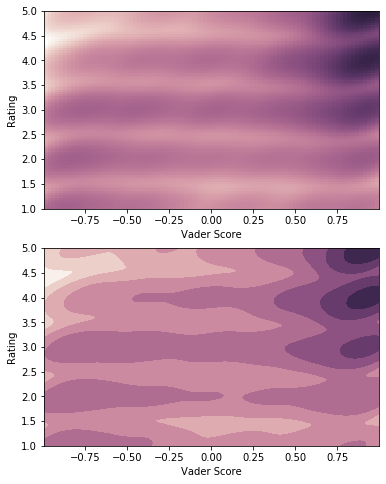

In [ ]:
heatmaps(x,y,'Vader Score','Rating','Vader Score','Rating')

High groudn truth ratings often have high Vader score, and for low ground truth ratings, more have low Vader score, which is also consistent with the deeper colours in upper right and bottom left corns in the heatmap. However, for the neutral ratings (i.e. 3.0), there is no clear trend in the Vader score, they basically distribute equally. 

###(b)

In [ ]:
review_len = []
for r in finaldf['reviewCol']: 
  review_len.append(len(r.split()))

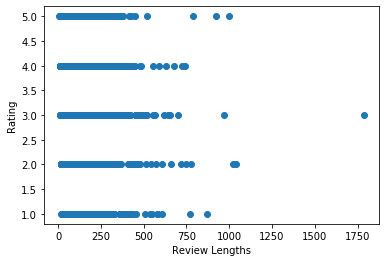

In [ ]:
scatterplot(review_len, y, 'Review Lengths', 'Rating')

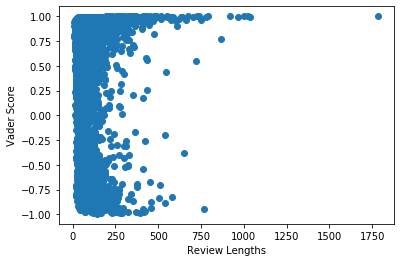

In [ ]:
scatterplot(review_len,x,'Review Lengths','Vader Score')

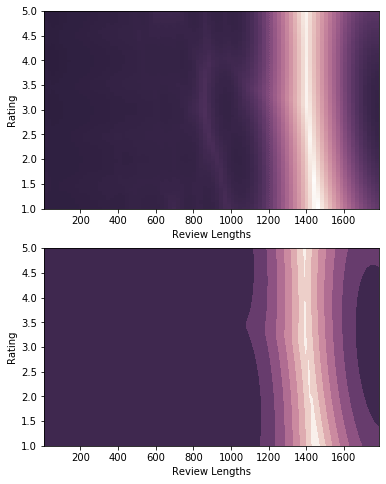

In [ ]:
heatmaps(np.array(review_len), y, 'Review Lengths', 'Rating', 'Review Lengths', 'Rating')

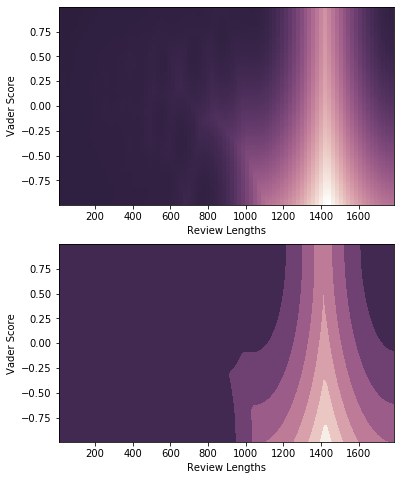

In [ ]:
heatmaps(np.array(review_len), x, 'Review Lengths', 'Vader Score', 'Review Lengths', 'Vader Score')

When people are very happy or very unsatisfied with their stay, they tend to write lengthy reviews whereas when they are neutral, they do not usually provide long comments. 

Also, from the Vader score, we can see that people tend to say more when the sentiment is positive than when it is negative. But similar trend cannot be found on the ground truth rating, which inidicates that one of the measures is not so reliable. 

###(c)

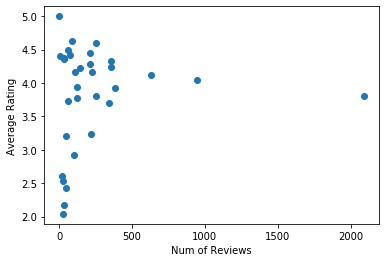

In [ ]:
review_counts_list = review_counts.values
x = [ct[1] for ct in review_counts_list]
y = averageRating['ratingScore'].values
scatterplot(x,y,'Num of Reviews', 'Average Rating')

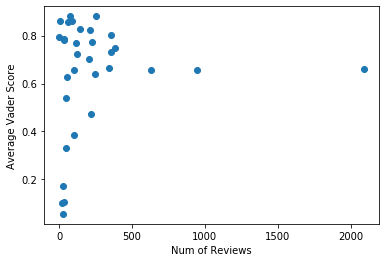

In [ ]:
x = [ct[1] for ct in review_counts_list]
y = averageRating['vader'].values
scatterplot(x,y,'Num of Reviews', 'Average Vader Score')

There are slightly more hotels have overall positive reviews. Also, the number of reviews for hotels that have postive reviews tend to have more reviews. But these trends do not seem so conlcusive. 